In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dsdszzz","key":"fdb5fcc330df3b6a4683c4dc90b77a94"}'}

In [2]:
ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c 2022-samsung-ds-competition-co-gas-data
!ls
!unzip 2022-samsung-ds-competition-co-gas-data.zip

 97% 184M/189M [00:00<00:00, 229MB/s]
100% 189M/189M [00:00<00:00, 216MB/s]
2022-samsung-ds-competition-co-gas-data.zip  kaggle.json  sample_data
Archive:  2022-samsung-ds-competition-co-gas-data.zip
  inflating: sample_solution.csv     
  inflating: test_data.csv           
  inflating: train_data.csv          


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)
from sklearn.linear_model import LinearRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import xgboost as xgb

import pandas as pd
import os
        
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report
from sklearn.model_selection import KFold, cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)

import numpy as np

from scipy.signal import butter, filtfilt

In [6]:
# regression models

def xgb_regression():
    multioutputregressor = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                    max_depth = 5, alpha = 10, n_estimators = 10)
    return multioutputregressor
    
def random_forest_regression():
    multioutputregressor = RandomForestRegressor(n_estimators = 10, max_depth = 5, criterion = 'absolute_error', n_jobs = -1, random_state = 0)
    return multioutputregressor

def linear_regression():
    multioutputregressor = LinearRegression(n_jobs = -1)
    return multioutputregressor

def ridge_regression():
    multioutputregressor = Ridge(random_state = 0)
    return multioutputregressor

def lasso_regression():
    multioutputregressor = Lasso(random_state = 0)
    return multioutputregressor

def kneighbors_regression():
    multioutputregressor = KNeighborsRegressor(random_state = 0)
    return multioutputregressor

def decisiontree_regression():
    multioutputregressor = DecisionTreeRegressor(random_state = 0)
    return multioutputregressor

def gb_regression():
    multioutputregressor = GradientBoostingRegressor(random_state = 0)
    return multioutputregressor

def ab_regression():
    multioutputregressor = AdaBoostRegressor(random_state = 0)
    return multioutputregressor

In [87]:
def post_process_pred_ver1(y_pred):
    y_pred = np.where(y_pred < 0, 0, y_pred)
    y_pred = np.where(y_pred > 533.33, 533.33, y_pred)
    return y_pred

def post_process_pred_ver2(y_pred, y_class_val_list):
    """
    use 'train_y' for 'y_class_val_list'
    """
    y_cls = np.sort(np.unique(y_class_val_list))
    y_cls_mid = [(y_cls[i] + y_cls[i + 1])/2 for i in range(len(y_cls) - 1)]
    y_pred_mapped = y_cls[np.searchsorted(y_cls_mid, y_pred)]
    return y_pred_mapped

def post_process_pred_ver3(y_pred, y_class_val_list):
    """
    use 'train_y' for 'y_class_val_list'
    """
    y_cls = np.sort(np.unique(y_class_val_list))
    y_cls_mid = [(y_cls[i] + y_cls[i + 1])/2 for i in range(len(y_cls) - 1)]
    y_cls_mid[0] = 150
    y_pred_mapped = y_cls[np.searchsorted(y_cls_mid, y_pred)]
    return y_pred_mapped

class Y_PRED_CLASSIFIER:
    def __init__(self, y_pred, y_real):
        self.y_pred_clf = self.create_y_pred_clf(y_pred, y_real)

    def create_y_pred_clf(self, y_pred, y_real):
        """
        """
        from sklearn.naive_bayes import GaussianNB
        y_pred_clf = GaussianNB().fit(y_pred.reshape(-1, 1), y_real.astype(str))
        return y_pred_clf

    def post_process_pred_ver4(self, y_pred):
        """
        y_pred_clf = create_y_pred_clf(y_pred, y_real):
        """
        y_pred_mapped = self.y_pred_clf.predict(y_pred.reshape(-1, 1)).astype(float)
        return y_pred_mapped

def get_mae(y_true, y_pred):
    return mean_absolute_error(y_true=y_true, y_pred=y_pred)

In [79]:
# PRE-PROCESSING  __ GET DATA

def preprocess_x(mode: int, _training_data: pd.DataFrame, _test_input_data: pd.DataFrame, scaling=True):
    """
    0. 전처리 X
    1. 초기값(1000) 제거 
    2. Data Shift(2000)
    3. filtering butter(4, 1/(100/2))
    4. 컬럼 선택(s2제거)
    """
    training_data = _training_data.copy()
    test_input_data = _test_input_data.copy()

    if mode == 0:
        train_x = np.array(training_data.values[:,3:], dtype=np.float64)
        train_y = np.array(training_data.values[:,2], dtype=np.float64)
        test_x = np.array(test_input_data.values[:,2:], dtype=np.float64)

    elif mode == 1: #
        train_x = np.array(training_data.values[1000:,3:], dtype=np.float64)
        train_y = np.array(training_data.values[1000:,2], dtype=np.float64)
        test_x = np.array(test_input_data.values[:,2:], dtype=np.float64)

    elif mode == 2: #
        for s in range(1,17):
            training_data['shf_s{}'.format(s)] = training_data['s{}'.format(s)].shift(-2000)
            test_input_data['shf_s{}'.format(s)] = test_input_data['s{}'.format(s)].shift(-2000)
        training_data = training_data.dropna()
        test_input_data = test_input_data.dropna()
        train_x = np.array(training_data.values[:,19:], dtype=np.float64)
        train_y = np.array(training_data.values[:,2], dtype=np.float64)
        test_x = np.array(test_input_data.values[:,18:], dtype=np.float64)

    elif mode == 3: # filtering ? 
        b, a = butter(4, 1/(100/2), btype='low', analog=False)  # fs = 100 Hz, fc = 1 Hz
        train_x = np.array([filtfilt(b, a, training_data[col_name].to_numpy()) for col_name in training_data.columns[3:]]).T
        train_y = np.array(training_data.values[:,2], dtype=np.float64)
        test_x = np.array([filtfilt(b, a, test_input_data[col_name].to_numpy()) for col_name in test_input_data.columns[2:]]).T

    elif mode == 4:
        # cols = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16']
        # cols = ['s1', 's9', 's11', 's13', 's15']
        cols = ['s1',
                # 's2', 
                's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16']
        
        train_x = np.array(training_data[cols].values, dtype=np.float64)
        train_y = np.array(training_data['CO'].values, dtype=np.float64)
        test_x = np.array(test_input_data[cols].values, dtype=np.float64)
    
    elif mode == 5: # Finally selected preprocessing
        for s in range(1,17):
            training_data['shf_s{}'.format(s)] = training_data['s{}'.format(s)].shift(-2000)
            test_input_data['shf_s{}'.format(s)] = test_input_data['s{}'.format(s)].shift(-2000)
        training_data = training_data.dropna()
        test_input_data = test_input_data.dropna()
        train_x = np.array(training_data.values[:,19:], dtype=np.float64)
        train_y = np.array(training_data.values[:,2], dtype=np.float64)
        test_x = np.array(test_input_data.values[:,18:], dtype=np.float64)

        b, a = butter(4, 1/(100/2), btype='low', analog=False)  # fs = 100 Hz, fc = 1 Hz
        temp_train_x = np.array([filtfilt(b, a, train_x[:,i]) for i in range(len(train_x[0]))]).T
        temp_test_x = np.array([filtfilt(b, a, test_x[:,i]) for i in range(len(test_x[0]))]).T

        train_x = temp_train_x
        test_x = temp_test_x

    if scaling:
        scaler = StandardScaler().fit(train_x)
        train_x = scaler.transform(train_x)
        test_x = scaler.transform(test_x)

    return train_x, train_y, test_x

In [88]:
# POST-PROCESSING  __ Evaluate model

# def evaluate_model_after_postprocessing(mode: int, model, X_train, X_test, y_train, y_test, skip_training = True):
#     if not skip_training: 
#         model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)
#     if mode == 0: # without post-processing
#         pass
#     elif mode == 1: # change negative val into '0' 
#         y_pred = post_process_pred_ver1(y_pred)
#     elif mode == 2: # mapping predicted val to the closedt class
#         y_pred = post_process_pred_ver2(y_pred, np.concatenate([train_y, y_train]))
#     elif mode == 3: # change threshold; CLASS '0'
#         y_pred = post_process_pred_ver3(y_pred, np.concatenate([train_y, y_train]))
#     elif mode == 4: # use Gaussian Naive Bayes 
#         y_pred_clf = Y_PRED_CLASSIFIER(model.predict(X_train), y_train)
#         y_pred = y_pred_clf.post_process_pred_ver4(y_pred)
#     mae = get_mae(y_test, y_pred)
#     return mae

def evaluate_model_after_postprocessing(mode: int, model, X_train, X_test, y_train, skip_training = True):
    if not skip_training: 
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    if mode == 0: # without post-processing
        pass
    elif mode == 1: # change negative val into '0' 
        y_pred = post_process_pred_ver1(y_pred)
    elif mode == 2: # mapping predicted val to the closedt class
        y_pred = post_process_pred_ver2(y_pred, np.concatenate([train_y, y_train]))
    elif mode == 3: # change threshold; CLASS '0'
        y_pred = post_process_pred_ver3(y_pred, np.concatenate([train_y, y_train]))
    elif mode == 4: # use Gaussian Naive Bayes 
        y_pred_clf = Y_PRED_CLASSIFIER(model.predict(X_train), y_train)
        y_pred = y_pred_clf.post_process_pred_ver4(y_pred)
    
    return y_pred

## Preprocessing Performance with Linear Regressor

In [96]:
"""
0. 전처리 X
1. 초기값(1000) 제거 
2. Data Shift(2000)
3. filtering butter(4, 1/(100/2))
4. 컬럼 선택(s2제거)
"""
training_data = pd.read_csv('train_data.csv')
test_input_data = pd.read_csv('test_data.csv')

train_x, train_y, test_x = preprocess_x(5, training_data, test_input_data)
model = linear_regression()

"""
0. without post-processing
1. change negative val into '0' 
2. mapping predicted val to the closedt class
3. change threshold; CLASS '0'
4. use Gaussian Naive Bayes 
"""
y_pred_train = evaluate_model_after_postprocessing(4, model, train_x, train_x, train_y, skip_training=False)
y_pred_test = evaluate_model_after_postprocessing(4, model, train_x, test_x, train_y, skip_training=False)
mae = get_mae(train_y, y_pred_train)
print(f'score = {mae}')

score = 16.515119101541703


(array([5.22869e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.70142e+05,
        1.09224e+05, 2.20770e+04, 0.00000e+00, 4.53000e+02, 1.68880e+04]),
 array([  0.   ,  53.333, 106.666, 159.999, 213.332, 266.665, 319.998,
        373.331, 426.664, 479.997, 533.33 ]),
 <a list of 10 Patch objects>)

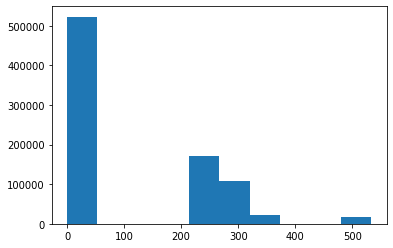

In [97]:
sample_submission = pd.read_csv('sample_solution.csv')
pred_test_padded = np.pad(y_pred_test, (0,sample_submission.shape[0]-y_pred_test.shape[0]), 'constant', constant_values=0)
sample_submission['CO'] = pred_test_padded
sample_submission.to_csv('predicted_output.csv', index=False) 

import matplotlib.pyplot as plt
plt.hist(pred_test_padded)

In [98]:
!kaggle competitions submit -c 2022-samsung-ds-competition-co-gas-data -f predicted_output.csv -m "Test"

100% 10.4M/10.4M [00:02<00:00, 5.02MB/s]
Successfully submitted to 2022 Samsung DS competition - CO gas data